In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

In [3]:
# Boundary condition 
coefii = 10

# X_0 = 0  #del
# Y_0 = 0     #w
X_0_v = -1/coefii
Y_0_v = 383.9911/coefii

In [4]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

def F_E1(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    return (X_prime+ws-Y)
    # return X_prime+ws-Y 

def F_E2(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    # return Y_prime
    return Y_prime-K1+K2*np.sin(coefii*X)+K3*(-ws+Y)*coefii

In [5]:
# # Differential equation's exact solution - for comparison
# def X_t(t):
#     # return X_0_v*np.cos(t)+(3*X_0_v+2*Y_0_v)*np.sin(t)
#     return 0

# def Y_t(t):
#     return 0

In [6]:
t=np.random.uniform(0,1,size=100,requires_grad=False)

In [7]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [8]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [9]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [10]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [11]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(qml.draw(quantum_net)(theta1,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     
M0 = 
[6.19159764]
M1 = 
[4.11723857]
M2 = 
[4.64655766]
M3 = 
[5.76077744]


In [12]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):

    r1=quantum_net(theta,t)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[0]+w[1]*r1+w[2]*r1**2
    # r1=quantum_net(theta,x)
    return r1

In [13]:
# add the classical layer   #TODO
def classical_quantum_net_efficient(r1,w):
    return w[0]+w[1]*r1+w[2]*r1**2

In [14]:
def classical_quantum_net_prime(theta,w,t):



    r1=quantum_net(theta,t)[0]

    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[1]*r1_prime+2*w[2]*r1_prime*r1


In [15]:
def classical_quantum_net_double_prime(theta,w,t):

   r1=quantum_net(theta,t)[0]
   r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 


   #Calculate double prime
   F_pos_pos_pi = quantum_net(theta,t+np.pi)[0]
   F_phi = quantum_net(theta,t)[0]
   F_phi_neg_pi = quantum_net(theta,t-np.pi)[0]
   r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)


   return w[1]*r1_double_prime+2*w[2]*(r1_prime*r1_prime+r1*r1_double_prime)

In [16]:
# def square_loss(labels,predictions):
#     loss=0
#     for l,p in zip(labels,predictions):
#         loss=loss+(l-p)**2
#     loss=loss/len(labels)
#     return loss

In [17]:
# #loss boundary
# def loss_b(U_predict):
    
    

In [18]:
# def cost(theta1,theta2,w1,w2,t):

#     # loss inner points
#     loss_i = 0

#     X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
#     X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
#     Y_t_pred = X_t_pred+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     Y_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

#     loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

#     # # loss boundary points
#     # loss_b = 0
#     # X_0_pred = classical_quantum_net(theta1,w1,0)
#     # Y_0_pred = classical_quantum_net(theta2,w2,0)

#     # # print(U_0)
#     # loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
#     # return 0.2*loss_b + 0.8*loss_i
#     return loss_i

In [19]:
# def cost_efficient(theta1,w1,t):
#     # loss inner points
#     loss_i = 0
#     # print('-------')
#     r1 = np.array([quantum_net(theta1,t)[0] for t in t])

#     # print(r1)

#     r1_prime = np.array([qml.grad(quantum_net,argnum=1)(theta1,np.tensor(t)) for t in t])
#     #Calculate double prime
#     F_pos_pos_pi = np.array([quantum_net(theta1,t+np.pi)[0] for t in t])
#     # print(len(F_pos_pos_pi))
#     F_phi = r1
#     F_phi_neg_pi = np.array([quantum_net(theta1,t-np.pi)[0] for t in t])
#     r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)

#     # print(r1)
#     # print(r1_prime)
#     # print(r1_double_prime)

#     X_t_pred = classical_quantum_net_efficient(r1=theta1,w=w1)
#     X_t_prime = classical_quantum_net_prime_efficient(r1=theta1,r1_prime=r1_prime,w=w1)
    
#     Y_t_pred = X_t_prime+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     Y_t_prime = classical_quantum_net_double_prime_efficient(r1=theta1,r1_prime=r1_prime,r1_double_prime=r1_double_prime,w=w1)

#     loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

#     # # loss boundary points
#     loss_b = 0
#     X_0_pred = classical_quantum_net(theta1,w1,0)
#     Y_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

#     # # print(U_0)
#     loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
#     # return loss_b + loss_i
#     return 0.2*loss_b + 0.8*loss_i

    # return loss_i

In [20]:
def cost(theta1,w1,t):

    # loss inner points
    loss_i = 0

    X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
    X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
    Y_t_pred = X_t_prime+ws
    # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
    Y_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

    loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
    loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

    # # loss boundary points
    loss_b = 0
    X_0_pred = classical_quantum_net(theta1,w1,0)
    Y_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

    # # print(U_0)
    loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
    return loss_b + loss_i
    # return 0.2*loss_b + 0.8*loss_i

    return loss_i

In [21]:
w1=np.zeros(3,requires_grad=True)
# w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [22]:
start=now()
print(start)

2023-08-11 17:12:30.244876


In [23]:
epochs=100
cost_max = 10000
theta1_best = None
w1_best = None

for e in range(1,epochs+1):

    # (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    (theta1,w1,_),_cost=opt.step_and_cost(cost,theta1,w1,t)

    if _cost<cost_max:
        cost_max = _cost
        theta1_best = theta1
        w1_best = w1

    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')

Epoch: 1 | Cost: 0.749999999999994
Epoch: 2 | Cost: 0.596609200710584
Epoch: 3 | Cost: 0.4869056039807968
Epoch: 4 | Cost: 0.7861657196997701
Epoch: 5 | Cost: 0.5123955058789966
Epoch: 6 | Cost: 0.47842624775157105
Epoch: 7 | Cost: 0.5456308553029012
Epoch: 8 | Cost: 0.5709858509494483
Epoch: 9 | Cost: 0.5702805614539705
Epoch: 10 | Cost: 0.5536735471832712
Epoch: 11 | Cost: 0.5196294812659087
Epoch: 12 | Cost: 0.46533520992369415
Epoch: 13 | Cost: 0.4116697241608857
Epoch: 14 | Cost: 0.4152718669604758
Epoch: 15 | Cost: 0.46350281972920493
Epoch: 16 | Cost: 0.4510627210532568
Epoch: 17 | Cost: 0.3877306887071176
Epoch: 18 | Cost: 0.3593619967057584
Epoch: 19 | Cost: 0.3707281137064999
Epoch: 20 | Cost: 0.38233211060873695
Epoch: 21 | Cost: 0.37756649675485754
Epoch: 22 | Cost: 0.3552593676162408
Epoch: 23 | Cost: 0.32225625047916184
Epoch: 24 | Cost: 0.2995585134915388
Epoch: 25 | Cost: 0.30548841803570354
Epoch: 26 | Cost: 0.3119220614341409
Epoch: 27 | Cost: 0.288278033472642
Epoch:

In [26]:
# print(_cost)
t=np.random.uniform(0,1,size=100,requires_grad=False)
pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=(np.array([classical_quantum_net_prime(theta1,w1,t) for t in t])+ws)
print(pred_train_X)
print(pred_train_Y)
# pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

[ 0.01001618  0.13607451  0.16591741  0.05862456  0.04171117  0.16276855
 -0.04106611  0.13422103  0.16708144  0.14125931  0.16647977  0.16590649
 -0.09209686  0.15075802  0.15387533 -0.06908035  0.15802815  0.15677347
  0.05241646  0.1668995   0.15972658 -0.03947423  0.15829062  0.15915905
  0.16261856  0.07616127  0.16422903 -0.01340657  0.14103659  0.16518518
  0.06170718  0.16227738 -0.02876827 -0.02774177  0.16595378  0.1664086
 -0.02750603  0.16669857 -0.00514699  0.10088775  0.08978993 -0.07395153
  0.16430551  0.16696041 -0.01947623  0.06512497  0.11352364 -0.08403534
  0.11677357 -0.03926095  0.13568851 -0.05202706  0.16413749  0.02514077
  0.05468317  0.16713513  0.15975649  0.16716429  0.09062875  0.01459396
  0.07319815  0.09633426  0.16398985  0.11571917  0.1642795   0.02043051
  0.07342842  0.10244299  0.1647059   0.16606059  0.1441039  -0.0036078
  0.07602586  0.15008936  0.04022222  0.11147897 -0.07319789 -0.08010323
 -0.08885744  0.10672643  0.10361296  0.09613664  0.1

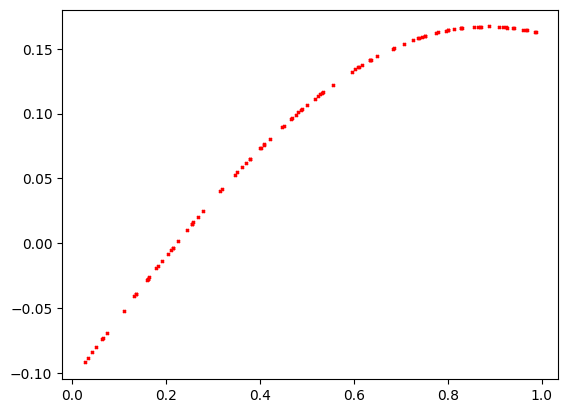

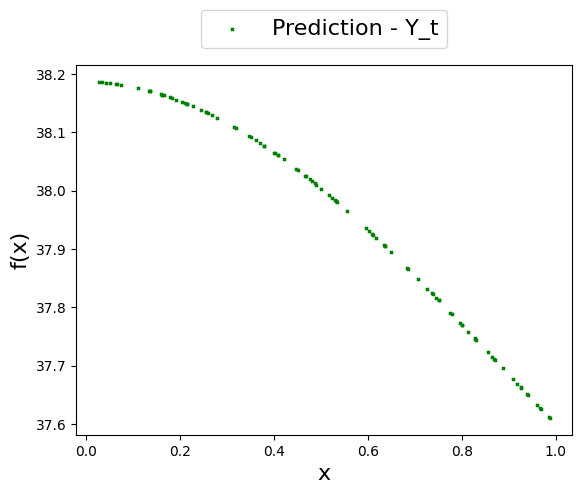

In [27]:
plt.figure()
# plt.scatter(t,X_t(t),facecolors='none', edgecolors='r', label='True - X_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - X_t')
# plt.scatter(t,Y_t(t),facecolors='none', edgecolors='g', label='True - Y_t')
plt.figure()
plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - Y_t')

plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()